In [18]:
import argparse, os
import numpy as np
from himalaya.backend import set_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import time
import pickle


import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!

torch.autograd.set_detect_anomaly(True)

/Users/balbirsingh/anaconda3/envs/DeepLearning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#python ridge.py --target blip --roi early ventral midventral midlateral lateral parietal  --subject subj01
#python ridge.py --target init_latent --roi early --subject subj01

In [5]:
target = 'z'
#roi = ['early', 'ventral', 'midventral', 'midlateral','lateral','parietal']
roi = ['early']
subject = 'subj01'
backend = set_backend("numpy", on_error="warn")


In [6]:
mridir = f'../../mrifeat/{subject}/'
featdir = '../../nsdfeat/subjfeat/'
savedir = f'../..//fmri/{subject}/'
os.makedirs(savedir, exist_ok=True)

In [7]:
if target == 'c' or target == 'z': # CVPR
    alpha = [0.000001,0.00001,0.0001,0.001,0.01, 0.1, 1]
else: # text / GAN / depth decoding (with much larger number of voxels)
    alpha = [10000, 20000, 40000]

In [8]:
ridge = RidgeCV(alphas=alpha)

preprocess_pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=True),
)
pipeline = make_pipeline(
    preprocess_pipeline,
    ridge,
)  

In [9]:
Y = []
Y_te = []
for croi in roi:
    if 'conv' in target: # We use averaged features for GAN due to large number of dimension of features
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_ave_tr.npy').astype("float32")
    else:
        cX = np.load(f'{mridir}/{subject}_{croi}_betas_tr.npy').astype("float32")
    cX_te = np.load(f'{mridir}/{subject}_{croi}_betas_ave_te.npy').astype("float32")
    Y.append(cX)
    Y_te.append(cX_te)
Y = np.hstack(Y)
Y_te = np.hstack(Y_te)

In [10]:
X = np.load(f'{featdir}/{subject}_each_{target}_tr.npy').astype("float32").reshape([Y.shape[0],-1])

In [11]:
X_te = np.load(f'{featdir}/{subject}_ave_{target}_te.npy').astype("float32").reshape([Y_te.shape[0],-1])

In [12]:
Y.shape

(24980, 5917)

In [13]:
Y_te.shape

(982, 5917)

In [12]:
print(f'Now making decoding model for... {subject}:  {roi}, {target}')
print(f'X {X.shape}, Y {Y.shape}, X_te {X_te.shape}, Y_te {Y_te.shape}')

Now making decoding model for... subj01:  ['early'], z
X (24980, 4096), Y (24980, 5917), X_te (982, 4096), Y_te (982, 5917)


In [101]:
pipeline.fit(X, Y)

In [17]:
scores = pipeline.predict(X_te)

In [18]:
scores[0]

array([-871.7748 ,  381.46893,  709.52094, ...,   66.04494,  -68.46825,
        106.3498 ], dtype=float32)

In [19]:
Y_te[0]

array([ 2989.,   -13., -1054., ...,  -194.,  -395.,  -321.], dtype=float32)

In [20]:
rs = correlation_score(Y_te.T,scores.T)
print(f'Prediction accuracy is: {np.mean(rs):3.3}')

Prediction accuracy is: 0.0193


In [18]:
np.save(f'{savedir}/{subject}_{"_".join(roi)}_scores_{target}.npy',scores)

In [19]:
with open(f'{savedir}reconstruct_fmri_model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [13]:
# Check for NaN or Infinite values in X and Y
if np.isnan(X).any() or np.isinf(X).any() or np.isnan(Y).any() or np.isinf(Y).any():
    raise ValueError("Input data contains NaN or infinite values.")

    # Check for NaN or Infinite values in X and Y
if np.isnan(X_te).any() or np.isinf(X_te).any() or np.isnan(Y_te).any() or np.isinf(Y_te).any():
    raise ValueError("Input data contains NaN or infinite values.")


In [19]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):


        super(NN, self).__init__()
        # Our first linear layer take input_size, in this case 784 nodes to 50
        # and our second linear layer takes 50 to the num_classes we have, in
        # this case 10.
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 1024)
        self.o = nn.Linear(1024, num_classes) 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.o(x)
        return x


In [21]:
# Hyperparameters
input_size = 4096
num_classes = 5917
learning_rate = 0.001
batch_size = len(X)
num_epochs = 40


In [22]:
# Set device cuda for GPU if it's available otherwise run on the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")





# Create dataset from several tensors with matching first dimension
# Samples will be drawn from the first dimension (rows)

# Load Data
train_dataset = TensorDataset( torch.Tensor(X), torch.Tensor(Y) )
test_dataset = TensorDataset( torch.Tensor(X_te), torch.Tensor(Y_te) )

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Initialize network
model = NN(input_size=input_size, num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train Network
for epoch in range(num_epochs):
    losses = 0
    for batch_idx, (data, targets) in enumerate(tqdm(train_loader)):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        #data = data.reshape(data.shape[0], -1)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        
        losses+=loss.item()
        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()
        
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {losses/(len(train_loader)*1e6):.4f}')

In [54]:
scores = model(torch.tensor(X_te)).detach().numpy() 

In [55]:
rs = correlation_score(Y_te.T,scores.T)
print(f'Prediction accuracy is: {np.mean(rs):3.4}')

Prediction accuracy is: 0.8341


In [56]:
Y_te.T.shape

(5917, 982)

In [57]:
rs.shape

(982,)

In [1]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the graph
plt.figure(figsize=(16, 10))
plt.plot(rs, color = 'b')
plt.xlabel('test images')
plt.ylabel('correlation score')
plt.title('Correlation score between orignal fMRI data and predicted fMRI data (preprocessed form)- Neural Network')
plt.show()

## save model

In [60]:
path = f'{savedir}reconstruct_fmri_model_NN.pth'
torch.save(model.state_dict(), path)

## load model

In [49]:
path = f'{savedir}reconstruct_fmri_model_NN.pth'

model2 = NN(input_size,num_classes)
model2.load_state_dict(torch.load(path))
model2.eval()

NN(
  (fc1): Linear(in_features=4096, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=512, bias=True)
  (fc5): Linear(in_features=512, out_features=1024, bias=True)
  (o): Linear(in_features=1024, out_features=5917, bias=True)
)

In [50]:
scores = model2(torch.tensor(X_te)).detach().numpy() 

In [51]:
rs = correlation_score(Y_te.T,scores.T)
print(f'Prediction accuracy is: {np.mean(rs):3.4}')

Prediction accuracy is: 0.8341


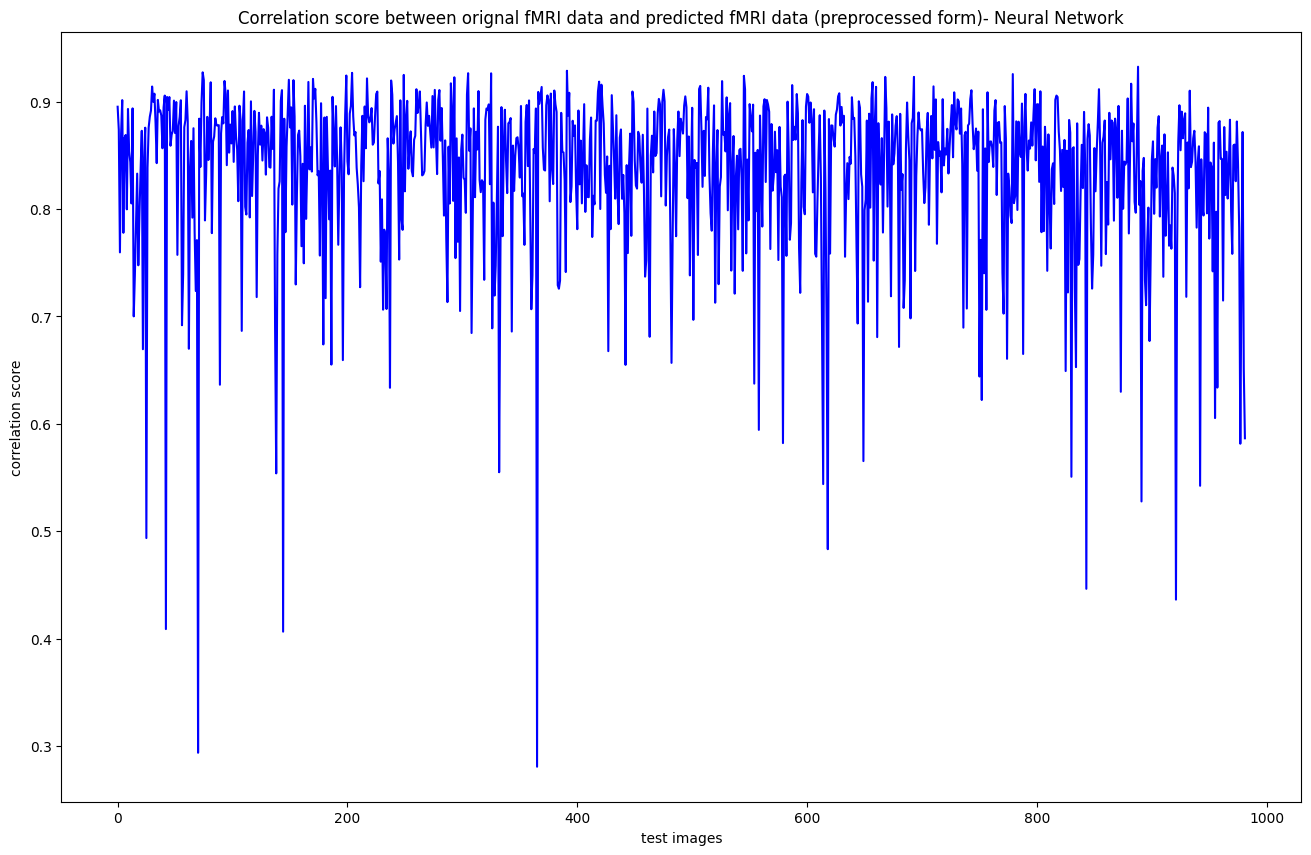

In [52]:
import numpy as np
import matplotlib.pyplot as plt


# Plotting the graph
plt.figure(figsize=(16, 10))
plt.plot(rs, color = 'b')
plt.xlabel('test images')
plt.ylabel('correlation score')
plt.title('Correlation score between orignal fMRI data and predicted fMRI data (preprocessed form)- Neural Network')
plt.show()

In [100]:
unique_elements, counts = np.unique(np.round(rs,2), return_counts=True)
unique_elements

array([0.28, 0.29, 0.4 , 0.41, 0.44, 0.48, 0.49, 0.52, 0.54, 0.55, 0.56,
       0.57, 0.58, 0.59, 0.61, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69,
       0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94], dtype=float32)

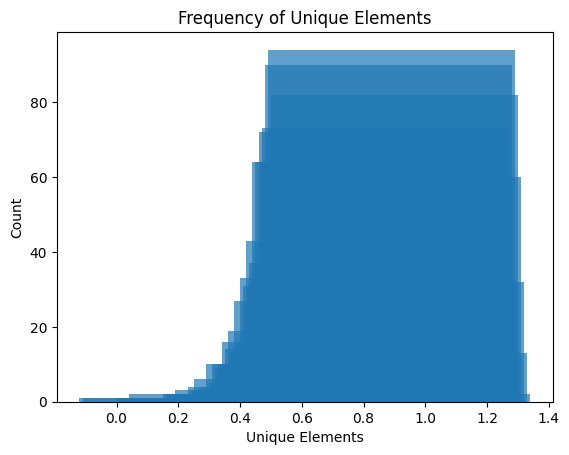

In [99]:
# Plotting the bar chart
plt.bar(unique_elements, counts, align='center', alpha=0.7)
plt.xlabel('Unique Elements')
plt.ylabel('Count')
plt.title('Frequency of Unique Elements')
plt.show()